# Version Memo

1. Feature Engineering
    - Base Features From ONELUX
      <br>https://www.kaggle.com/code/leehomhuang/catboost-baseline-with-lots-features-inference
    
    - Date Related Features
    
    - Add Mouse-Tracking Related Features
    
    - number of Features by Questions 
      <br>1301, 1931, 2282 + predict_proba for Prior-Questions
      
      
2. Fitting LGBM Single model
    - Tuned params
    - Best threshold : 0.614
    - CV : 0.705 / LB public 0.699,  private 0.701
    - output : (AF)LGBM_v0.1.pickle

# Files Info.

<br>
- init_data.pickle : 용량을 줄이기 위해 raw 데이터를 전처리한 데이터
<br><br>
- (AF)trainset.pickle : 특징공학을 거친 학습용 데이터셋
<br><br>
- (AF)LGBM_v0.1.pickle : 학습된 18개 모델, feature 리스트, 결정경계 기준, feature_importance 정보
<br><br>

# Import Libraries

In [25]:
import re
import numpy as np
import pandas as pd
import polars as pl
import pickle
from tqdm import tqdm

import matplotlib.pylab as plt
import seaborn as sns 

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

from lightgbm import LGBMClassifier

import gc
_ = gc.collect()

import warnings
warnings.simplefilter(action='ignore')

In [26]:
# Load train_y dataset
with open('./data/init_data.pickle', 'rb') as f:
    init_data = pickle.load(f)
train_y = init_data["train_y"]

del init_data
_ = gc.collect()

# Load the train_x dataset that has been feature engineered.
with open("./data/(AF)trainset.pickle", 'rb') as f:
    train_dfs = pickle.load(f)

# 1. Fit LGBM Model with Tuned HP

In [27]:
# Tuned hyperparameters
params = {'objective': 'binary',
          'boosting_type': 'gbdt',
          'learning_rate': 0.0037464232119058033,
          'reg_lambda': 0.003706555353020563,
          'reg_alpha': 12,
          'max_depth': 8,
          'n_estimators': 9999,
          'early_stopping_round': 50,
          'subsample': 0.8,
          'colsample_bytree': 0.5,
          'n_jobs': -1,
          'metric': 'binary_logloss',
          'device_type' : "gpu"
         }

### Memo

- 5 fold StratifiedKFold 사용

- 18문제 모델을 차례로 구축하되, 5 fold 중 최고 Macro f1-score를 기록한 모델을 선택

- OOF 사용해서 최적의 결정경계 탐색

- 이전 문제에 대한 예측 확률을 feature로 추가
  <br>ex) Q4 모델 학습 시, Q1~Q3 예측확률 사용
  
-> 최종 선택된 Q1~Q18의 features 개수
<br>[1301, 1302, 1303, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 2295, 2296, 2297, 2298, 2299]

In [28]:
%%time
best_models = {}
best_scores = {}
# Pred_proba values of prior-Questions
correctyn_df = {}
fi_dfs = {}

# Set 'out-of-fold' dataframe 
all_index = train_dfs[0].index.unique()
oof = pd.DataFrame(data = np.full([len(all_index), 18], 3), index = all_index)

""" Apply stratified k-fold method with 5 folds """
k_fold = 5
skf = StratifiedKFold(n_splits= 5, shuffle= True, random_state= 52521)

for q in tqdm(range(1, 19)) :
    print("\n========================================================================\n")
    print(f'## Question {q}')
    
    best_models[f"Q{q}"] = None
    best_scores[f"Q{q}"] = 0
    
    idx = 0 if q <= 3 else 1 if q <= 13 else 2
    train_f = train_dfs[idx]
    train_t = train_y.loc[train_y.q==q][["correct"]]
    
    print(f"\nQ{q} - features NB :", len(train_f.columns))
    
    for fold, (train_index, valid_index) in enumerate(skf.split(train_f, train_t)) :
        
        tr_users = train_f.iloc[train_index].index.values
        val_users = train_f.iloc[valid_index].index.values
        
        x_tr, x_val = train_f.loc[tr_users], train_f.loc[val_users]
        y_tr, y_val = train_t.loc[tr_users], train_t.loc[val_users]
        
        model = LGBMClassifier(**params)
        model.fit(x_tr, y_tr, eval_set = [(x_val, y_val)], verbose = 0)

        y_pred = model.predict(x_val).astype(int)
        oof.loc[val_users, q-1] = model.predict_proba(x_val.astype("float32"))[:,1]
        score = f1_score(y_val, y_pred, average = 'macro')

        if score > best_scores[f"Q{q}"] : 
            best_models[f"Q{q}"] = model
            best_scores[f"Q{q}"] = score
    
    print("\n  ** Best Scores : ", best_scores[f"Q{q}"], "\n\n")
    print()
    
    correctyn_df[f"Q{q}"] = best_models[f"Q{q}"].predict_proba(train_f.astype("float32"))[:, 1]
    train_dfs[idx][f"Q{q}"] = correctyn_df[f"Q{q}"].tolist()

    if q in [3, 13] :
        for ii in range(1, q+1) :
            train_dfs[idx+1][f"Q{ii}"] = correctyn_df[f"Q{ii}"].tolist()

print("\n========================================================================\n")

### Show feature_importances
for qq in range(1, 19) :
    fi = best_models[f"Q{qq}"].feature_importances_
    fn = best_models[f"Q{qq}"].feature_name_
    fidf = pd.DataFrame({"feature": fn, "importance" : fi})
    fidf.sort_values(by = 'importance', ascending = False, inplace = True)
    fi_dfs[f"Q{qq}"] = fidf
    print(f"\n\nQ{qq} Feature Importances : \n", fidf.head(20))

  0%|                                                                                           | 0/18 [00:00<?, ?it/s]



## Question 1

Q1 - features NB : 1301

  ** Best Scores :  0.6427975736129055 





  6%|████▍                                                                           | 1/18 [06:31<1:50:56, 391.57s/it]



## Question 2

Q2 - features NB : 1302

  ** Best Scores :  0.494908350305499 





 11%|████████▉                                                                       | 2/18 [09:11<1:08:06, 255.38s/it]



## Question 3

Q3 - features NB : 1303

  ** Best Scores :  0.4830499177180472 





 17%|█████████████▋                                                                    | 3/18 [11:53<53:07, 212.49s/it]



## Question 4

Q4 - features NB : 1934

  ** Best Scores :  0.6615375827521428 





 22%|█████████████████▊                                                              | 4/18 [19:54<1:14:22, 318.72s/it]



## Question 5

Q5 - features NB : 1935

  ** Best Scores :  0.6690572194739763 





 28%|██████████████████████▏                                                         | 5/18 [26:36<1:15:34, 348.82s/it]



## Question 6

Q6 - features NB : 1936

  ** Best Scores :  0.6131223925325725 





 33%|██████████████████████████▋                                                     | 6/18 [31:33<1:06:13, 331.14s/it]



## Question 7

Q7 - features NB : 1937

  ** Best Scores :  0.5965197647584307 





 39%|███████████████████████████████▉                                                  | 7/18 [36:38<59:08, 322.62s/it]



## Question 8

Q8 - features NB : 1938

  ** Best Scores :  0.5349228535203977 





 44%|████████████████████████████████████▍                                             | 8/18 [40:16<48:12, 289.23s/it]



## Question 9

Q9 - features NB : 1939

  ** Best Scores :  0.6264370032184758 





 50%|█████████████████████████████████████████                                         | 9/18 [45:26<44:22, 295.87s/it]



## Question 10

Q10 - features NB : 1940

  ** Best Scores :  0.6608355827038552 





 56%|█████████████████████████████████████████████                                    | 10/18 [49:59<38:29, 288.74s/it]



## Question 11

Q11 - features NB : 1941

  ** Best Scores :  0.5912106203588583 





 61%|█████████████████████████████████████████████████▌                               | 11/18 [54:05<32:08, 275.53s/it]



## Question 12

Q12 - features NB : 1942

  ** Best Scores :  0.46633790199311026 





 67%|██████████████████████████████████████████████████████                           | 12/18 [57:38<25:39, 256.63s/it]



## Question 13

Q13 - features NB : 1943

  ** Best Scores :  0.5907555038567944 





 72%|█████████████████████████████████████████████████████████                      | 13/18 [1:03:42<24:05, 289.14s/it]



## Question 14

Q14 - features NB : 2295

  ** Best Scores :  0.6076320392647319 





 78%|█████████████████████████████████████████████████████████████▍                 | 14/18 [1:09:59<21:02, 315.69s/it]



## Question 15

Q15 - features NB : 2296

  ** Best Scores :  0.678903173709037 





 83%|█████████████████████████████████████████████████████████████████▊             | 15/18 [1:16:47<17:10, 343.57s/it]



## Question 16

Q16 - features NB : 2297

  ** Best Scores :  0.4241720640351949 





 89%|██████████████████████████████████████████████████████████████████████▏        | 16/18 [1:21:57<11:06, 333.48s/it]



## Question 17

Q17 - features NB : 2298

  ** Best Scores :  0.42937506229442846 





 94%|██████████████████████████████████████████████████████████████████████████▌    | 17/18 [1:26:44<05:19, 319.34s/it]



## Question 18

Q18 - features NB : 2299

  ** Best Scores :  0.49179946580234685 





100%|███████████████████████████████████████████████████████████████████████████████| 18/18 [1:31:32<00:00, 305.14s/it]





Q1 Feature Importances : 
                                                 feature  importance
962           col_etd_fil_fq_val_chap1_finale_c_agg_max         950
458     col_etd_fil_rf_val_tunic.capitol_0.hall_agg_sum         912
240           col_etd_fil_fq_val_chap1_finale_c_agg_sum         589
29      col_etd_fil_rf_val_tunic.capitol_0.hall_agg_max         413
394                        col_etd_fil_lv_val_4_agg_sum         364
493                         col_md_fil_lv_val_3_agg_max         340
1032                   col_md_fil_fq_val_plaque_agg_std         312
343                     col_md_fil_nm_val_close_agg_std         311
1074                  col_etd_fil_fq_val_report_agg_max         299
995        col_md_fil_fq_val_retirement_letter_agg_mean         290
468      col_md_fil_rf_val_tunic.capitol_0.hall_agg_std         290
53                          col_md_fil_lv_val_3_agg_sum         279
1127               col_md_fil_fq_val_tobasement_agg_max         275
880   col_md_fil_

In [29]:
# feature_true : Used features for fitting by questions
feature_true = [best_models[f"Q{q}"].feature_name_ for q in range(1, 19)]
print("NB of Features : ", [len(feature_true[q-1]) for q in range(1, 19)])

NB of Features :  [1301, 1302, 1303, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 2295, 2296, 2297, 2298, 2299]


In [30]:
""" Calculate f1 Score with predicted y values & true y values applying variety thresholds """

true = oof.copy()
for k in range(18):
    tmp = train_y.loc[train_y.q == k+1].loc[all_index]
    true[k] = tmp.correct.values

scores = []; thresholds = []
best_score = 0; best_thr = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_thr = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

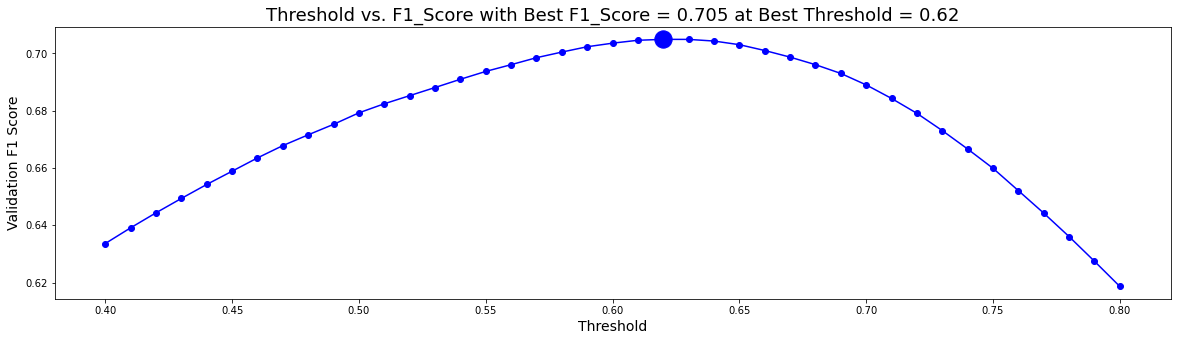

In [31]:
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_thr], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_thr:.3}',size=18)
plt.show()

In [32]:
# Save fitted Models by Questions
fit_all = {
            "feature_true" : feature_true,
            "best_model" : best_models, 
            "best_thr" : best_thr, 
            "fi_dfs" : fi_dfs}

with open('./data/(AF)LGBM_v0.1.pickle', 'wb') as f:
    pickle.dump(fit_all, f)